# Stock Price Prediction
The aim is to predict the future closing value of a certain stock using data of last **60 days**. <br>
<br>
The flow of the document is in the order:
1. Obtaining the data.
2. Data Preprocessing.
3. Building the Model.
4. Predicting
5. Conclusion


In [1]:
#importing the necessary libraries
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model

Using TensorFlow backend.


## Obtaining The Data
Using Yahoo Finance, the data of any stock can be obtained from a start to an end date

In [2]:
#get the data from 1st Jan 2012 to 31st March 2020
df = web.DataReader('AAPL', data_source = 'yahoo', start = '2012-01-01', end = '2020-03-31')

In [3]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.994907
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.268970
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.838169
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.380054
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.296970


## Data Preprocessing
The index of the data right now is Date. I need to reset the index of the dataframe and also sort it by month.

In [4]:
df = df.reset_index()

In [5]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.994907
1,2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.268970
2,2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.838169
3,2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.380054
4,2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.296970


In [6]:
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

In [7]:
#sorting the data by month
df['month'] = df['date'].dt.month
df.sort_values(by='date', inplace=True, ascending=True)
df.head()

,date,high,low,open,close,volume,adj_close,month
0,2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.994907,1
1,2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.268970,1
2,2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.838169,1
3,2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.380054,1
4,2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.296970,1


/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


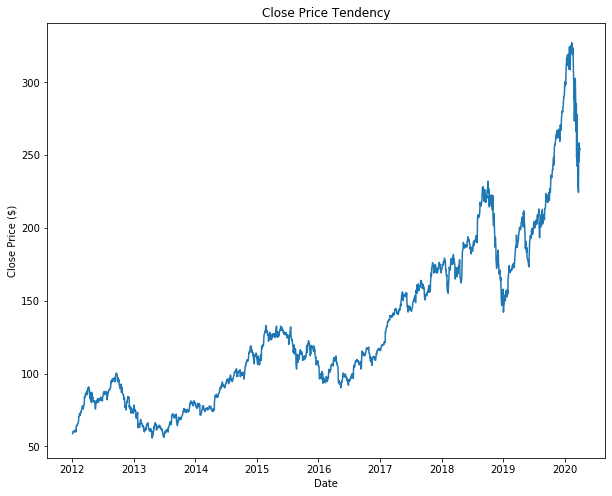

In [8]:
#visualize the data
plt.figure(figsize=(10,8))
plt.title("Close Price Tendency")
plt.plot(df['date'],df['close'])
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.show()

In [9]:
#We need only the "close" column of the dataset as that is what we'll be using to predict
data = df.filter(['close'])
dataset = data.values
training_dataset_len = math.ceil(len(dataset) *.8) 

## Splitting the data
In the above cell I calculate the training dataset length. Training dataset = 80%, Test = 20%

In [10]:
#Scaling the Dataset
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [11]:
#Splitting the data
train_data = scaled_data[0:training_dataset_len  , : ]
x_train = []
y_train = []

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

x_train = np.array(x_train)
y_train = np.array(y_train)
print("x_train.shape = " + str(x_train.shape))
print("y_train.shape = " + str(y_train.shape))

x_train.shape = (1600, 60)
y_train.shape = (1600,)


In [12]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1600, 60, 1)

## Building The Model

In [13]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(1))
model.add(LSTM(50))
model.add(Dropout(1))
model.add(Dense(1))
          
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose = 2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/1
 - 74s - loss: 4.8899e-04


In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


### Creating the Test Data Set

In [15]:
test_data = scaled_data[training_dataset_len - 60: , : ]

x_test = []
y_test =  dataset[training_dataset_len : , : ] 
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

## Predictions

In [16]:
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

### Calculating RMSE

In [17]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

8.180548555800215

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


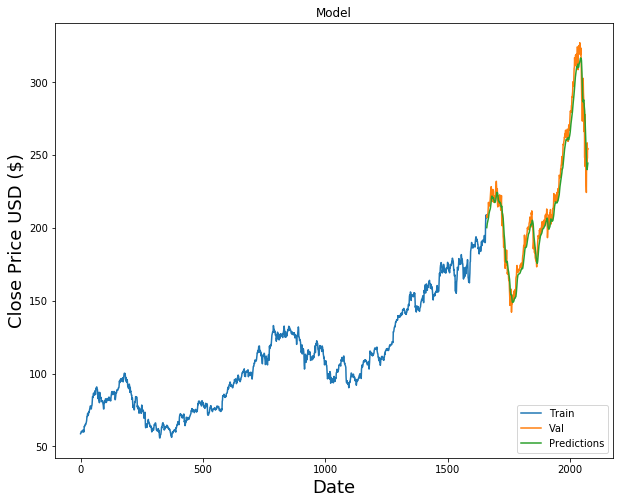

In [18]:
train = data[:training_dataset_len]
valid = data[training_dataset_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(10,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

### We can see the predictions to the actual prices below

In [19]:
valid

,close,Predictions
1660,207.250000,200.229111
1661,208.880005,201.737610
1662,207.529999,203.055573
1663,208.869995,203.930054
1664,209.750000,204.681213
1665,210.240005,205.380951
1666,213.320007,206.024857
1667,217.580002,206.960388
1668,215.460007,208.438904
1669,215.039993,209.665695


## Conclusion
It can be seen from the benchmark model that the RMSE of this model has decreased. Hence, this model works better.